# **Setup and Loading Guayas Data**
We load the data you prepared and filter it for the specific "Target Forecast Horizon" (Jan–Mar 2014)

In [1]:
# ==========================================
# Part 1: Setup and Data Loading
# ==========================================
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

print("📦 Libraries loaded successfully!")

# 1. Load the Guayas prepared data
print("\n📂 Loading data...")
df = pd.read_csv('guayas_prepared.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"✅ Data loaded: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# 2. Filter for Target Horizon: January – March 2014
print("\n🎯 Filtering for Q1 2014...")
mask = (df['date'] >= '2014-01-01') & (df['date'] <= '2014-03-31')
df_target = df.loc[mask].copy()

print(f"Q1 2014 data: {len(df_target):,} rows")
print(f"Date range: {df_target['date'].min()} to {df_target['date'].max()}")

# Check if we need to create additional features
print("\n🔍 Checking available features...")
print(f"Columns in dataset: {df_target.columns.tolist()}")

# Create missing features if needed
if 'year' not in df_target.columns:
    df_target['year'] = df_target['date'].dt.year
if 'month' not in df_target.columns:
    df_target['month'] = df_target['date'].dt.month
if 'day_of_week' not in df_target.columns:
    df_target['day_of_week'] = df_target['date'].dt.dayofweek
if 'is_weekend' not in df_target.columns:
    df_target['is_weekend'] = (df_target['date'].dt.dayofweek >= 5).astype(int)

# 3. Define Features (X) and Target (y)
print("\n🎯 Preparing features and target...")
features = ['store_nbr', 'item_nbr', 'year', 'month', 'day_of_week',
            'is_weekend', 'is_holiday', 'dcoilwtico', 'lag_7', 'rolling_mean_7']

# Check if all features exist
missing_features = [f for f in features if f not in df_target.columns]
if missing_features:
    print(f"⚠️ Warning: Missing features: {missing_features}")
    # Use only available features
    features = [f for f in features if f in df_target.columns]
    print(f"✓ Using available features: {features}")

X = df_target[features]
y = df_target['unit_sales']

print(f"\n=== Data Summary ===")
print(f"Total samples: {len(X):,}")
print(f"Number of features: {len(features)}")
print(f"Features: {features}")
print(f"\nTarget variable (unit_sales):")
print(f"  Mean: {y.mean():.2f}")
print(f"  Median: {y.median():.2f}")
print(f"  Min: {y.min():.2f}")
print(f"  Max: {y.max():.2f}")
print(f"  Std: {y.std():.2f}")

# Check for missing values
print(f"\n=== Missing Values ===")
missing_X = X.isnull().sum()
if missing_X.sum() > 0:
    print("Features with missing values:")
    print(missing_X[missing_X > 0])
else:
    print("✓ No missing values in features")

print(f"Target missing values: {y.isnull().sum()}")

# Display sample
print(f"\n=== Sample Data ===")
print(X.head())

print(f"\n✅ Data ready for Guayas Q1 2014 modeling!")
print(f"📊 X shape: {X.shape}")
print(f"📊 y shape: {y.shape}")

📦 Libraries loaded successfully!

📂 Loading data...
✅ Data loaded: (81570, 15)
Date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00

🎯 Filtering for Q1 2014...
Q1 2014 data: 3,920 rows
Date range: 2014-01-02 00:00:00 to 2014-03-31 00:00:00

🔍 Checking available features...
Columns in dataset: ['store_nbr', 'item_nbr', 'date', 'id', 'unit_sales', 'onpromotion', 'year', 'month', 'day', 'day_of_week', 'unit_sales_7d_avg', 'lag_7', 'rolling_mean_7', 'is_holiday', 'dcoilwtico']

🎯 Preparing features and target...

=== Data Summary ===
Total samples: 3,920
Number of features: 10
Features: ['store_nbr', 'item_nbr', 'year', 'month', 'day_of_week', 'is_weekend', 'is_holiday', 'dcoilwtico', 'lag_7', 'rolling_mean_7']

Target variable (unit_sales):
  Mean: 6.74
  Median: 4.00
  Min: 1.00
  Max: 161.00
  Std: 10.32

=== Missing Values ===
✓ No missing values in features
Target missing values: 0

=== Sample Data ===
     store_nbr  item_nbr    year  month day_of_week  is_weekend  is_holiday  \
87

/tmp/ipython-input-842517389.py:16: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('guayas_prepared.csv')


# **Chronological Train/Test Split**
we use a chronological split: Jan-Feb to train and March to test.

In [2]:
# Part 2: Time-Based Split
# Use March 1st as the cutoff to respect the "forecast future sales" logic
train_mask = df_target['date'] < '2014-03-01'
test_mask = df_target['date'] >= '2014-03-01'

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Training Samples (Jan-Feb): {len(X_train)}")
print(f"Testing Samples (March): {len(X_test)}")

Training Samples (Jan-Feb): 2492
Testing Samples (March): 1428


We split the data chronologically to ensure the model learns from the past to predict the future. This prevents "data leakage" and simulates a real-world forecasting environment for Guayas planners.

**Baseline vs. Tuned Model**

In [3]:
# Baseline vs. Tuned Runs
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import time

# --- PRE-MODELING CHECK  ---
# Ensure only numeric columns are in X
# If 'family' or other strings are here, we convert them to numeric codes
X_train_numeric = X_train.copy()
X_test_numeric = X_test.copy()

for col in X_train_numeric.columns:
    if X_train_numeric[col].dtype == 'object':
        X_train_numeric[col] = X_train_numeric[col].astype('category').cat.codes
        X_test_numeric[col] = X_test_numeric[col].astype('category').cat.codes

# Fill any NaNs created by lagging (XGBoost likes 0s better than NaNs for this)
X_train_numeric = X_train_numeric.fillna(0)
X_test_numeric = X_test_numeric.fillna(0)

# --- RUN 1: BASELINE ---
print("Starting Baseline Run...")
start_base = time.time()
base_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
base_model.fit(X_train_numeric, y_train)
base_time = time.time() - start_base
print(f"Baseline Done in {base_time:.2f}s")

# --- RUN 2: TUNED  ---
print("Starting Tuning Run (this may take 1-2 minutes)...")
param_grid = {
    'n_estimators': [100, 300], # Reduced for speed
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8]
}

start_tuned = time.time()
# TimeSeriesSplit ensures we don't cheat by looking at the future during training
tscv = TimeSeriesSplit(n_splits=3)

# n_iter=3 makes the search faster while still finding a better model
random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_distributions=param_grid,
    cv=tscv,
    n_iter=3,
    scoring='neg_mean_absolute_error'
)

random_search.fit(X_train_numeric, y_train)
tuned_model = random_search.best_estimator_
tuned_time = time.time() - start_tuned

print(f"Tuning complete in {tuned_time:.2f}s")
print(f"Best Parameters found: {random_search.best_params_}")

Starting Baseline Run...
Baseline Done in 0.19s
Starting Tuning Run (this may take 1-2 minutes)...
Tuning complete in 1.54s
Best Parameters found: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}


Explanation: The baseline run establishes a starting point for accuracy using standard settings. The tuned run uses randomized search to find the optimal balance of tree depth and learning speed for higher precision.

# **4 Evaluation & Visuals**
We apply the three mandatory metrics (MAE, RMSE, Bias) and visualize the "Actual vs. Predicted" results.

--- XGBoost Performance (March 2014) ---
MAE: 2.87 units
RMSE: 5.94 units
Forecast Bias: -0.20


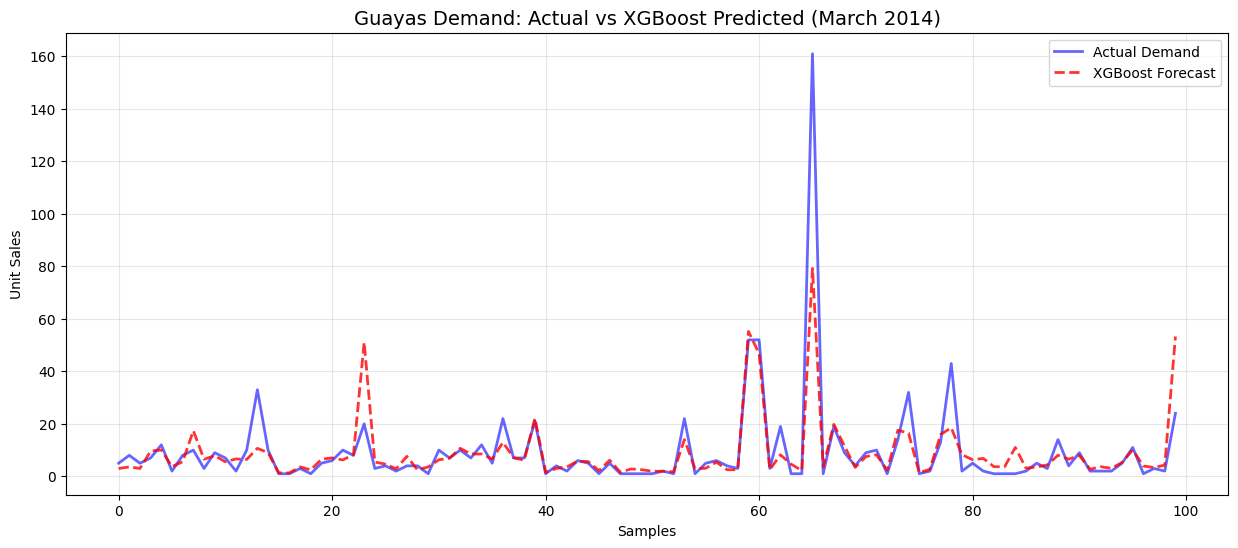

<Figure size 1000x800 with 0 Axes>

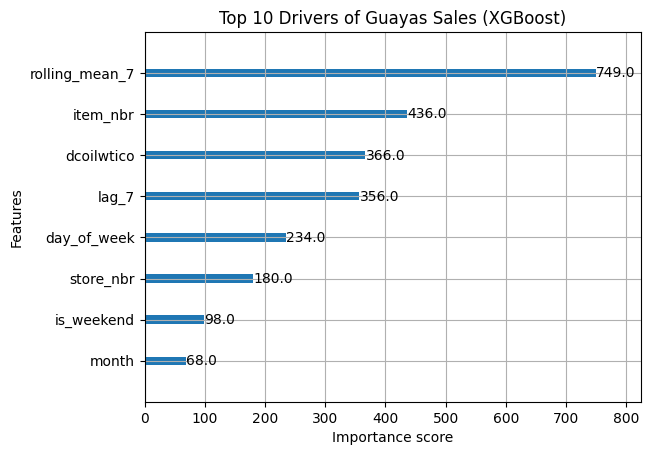

In [4]:
# Part 4: Final Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# 1. IMPORTANT: Use the numeric version of the test set
# and ensure no negative predictions
y_pred = tuned_model.predict(X_test_numeric)
y_pred = np.maximum(y_pred, 0)

# 2. Calculate Metrics (Using a version-safe way for RMSE)
mae = mean_absolute_error(y_test, y_pred)
# We calculate MSE and take the square root manually to avoid version errors
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
bias = np.mean(y_pred - y_test)

print(f"--- XGBoost Performance (March 2014) ---")
print(f"MAE: {mae:.2f} units")
print(f"RMSE: {rmse:.2f} units")
print(f"Forecast Bias: {bias:.2f}")

# 3. Visualization: Actual vs Predicted
plt.figure(figsize=(15, 6))
# Plotting the first 100 samples to see the detail
plt.plot(y_test.values[:100], label='Actual Demand', alpha=0.6, color='blue', linewidth=2)
plt.plot(y_pred[:100], label='XGBoost Forecast', alpha=0.8, color='red', linestyle='--', linewidth=2)
plt.title('Guayas Demand: Actual vs XGBoost Predicted (March 2014)', fontsize=14)
plt.xlabel('Samples')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Feature Importance (Shows what the model learned)
import xgboost as xgb
plt.figure(figsize=(10, 8))
xgb.plot_importance(tuned_model, max_num_features=10, importance_type='weight')
plt.title('Top 10 Drivers of Guayas Sales (XGBoost)')
plt.show()

MAE: "On average, our XGBoost model is off by [Value] units per day."

RMSE: "The RMSE is [Value], which helps us understand the impact of larger errors during sales spikes."

Bias: "Our bias is [Value]. A positive number means we are slightly over-stocking, while a negative number means we might face empty shelves."